In [2]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35_GWTC4_mid/Sep11_peak`


h_plot (generic function with 1 method)

# Load GWTC-4 Parameter Estimation Samples

In [3]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    O4a_dir::String
end

paths = Paths(
    "/mnt/home/ccalvk/ceph/GWTC-2.1", 
    "/mnt/home/ccalvk/ceph/GWTC-3", 
    "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
    "/mnt/home/sroy1/ceph/O4/O4a_final_PE"
)

Paths("/mnt/home/ccalvk/ceph/GWTC-2.1", "/mnt/home/ccalvk/ceph/GWTC-3", "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json", "/mnt/home/sroy1/ceph/O4/O4a_final_PE")

In [4]:
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)
all_pe = vcat(far_cut(all_pe), load_pe_from_dir_O4a(; dir=paths.O4a_dir); cols=:intersect)

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/35_GWTC4_mid/Sep11_peak/src/load.jl:26
Loading IGWN HDF5 Files 100%|████████████████████████████| Time: 0:00:46


Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.0939295,32.0239,-0.372615,0.805206,32.907,-0.983395,-0.122761,29.4119,0.71106,325.143,0.249548,0.138759,-0.323322,4.3655,0.867711,0.235285,0.0614407,26.7124,0.918436,510.159,68.7365,35.8294,61.4357,0.730616,1.20422,6.13794,1.95262,

In [5]:
groups_all_pe = groupby(all_pe, :gwname)

Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.0939295,32.0239,-0.372615,0.805206,32.907,-0.983395,-0.122761,29.4119,0.71106,325.143,0.249548,0.138759,-0.323322,4.3655,0.867711,0.235285,0.0614407,26.7124,0.918436,510.159,68.7365,35.8294,61.4357,0.730616,1.20422,6.13794,1.95262,

In [6]:
pe = mass_cut(all_pe, thresh=0.5)
groups = groupby(pe, :gwname)

Row,spin_2y,dec,chirp_mass,redshift,theta_jn,ra,a_1,chi_p_2spin,viewing_angle,mass_1_source,cos_tilt_2,spin_2x,mass_2,cos_iota,chi_eff,mass_2_source,psi_J,log_likelihood,symmetric_mass_ratio,phi_12,spin_2z,phase,a_2,beta,spin_1z,chirp_mass_source,mass_ratio,comoving_distance,total_mass,mass_1,total_mass_source,chi_p,tilt_1,phi_1,tilt_2,cos_tilt_1,iota,luminosity_distance,phi_2,cos_theta_jn,inverted_mass_ratio,spin_1y,phi_jl,psi,spin_1x,gwname
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,SubStrin…
1,0.0157482,-1.2029,30.9684,0.0968552,2.77079,1.28323,0.00150978,0.0142601,0.370807,37.7342,0.827167,0.000942395,30.7108,-0.931191,0.00928814,27.999,2.70339,320.05,0.244516,2.46959,0.0232219,3.78693,0.028074,0.00264939,-0.0010508,28.2338,0.742006,418.022,72.0998,41.3889,65.7332,0.0112211,2.3406,5.32462,0.596749,-0.695997,2.76846,458.427,1.51103,-0.932035,1.3477,-0.000887186,2.07373,1.12909,0.000623018,GW150914_095045
2,0.306186,-1.17447,31.6976,0.0858721,2.58701,1.12687,0.927965,0.804829,0.554584,36.8689,-0.708659,-0.277814,33.1735,-0.876785,0.0308062,30.5501,3.19656,324.407,0.247804,0.924199,-0.415259,1.61676,0.585979,0.294629,0.400422,29.1909,0.828614,371.601,73.2084,40.0349,67.419,0.837126,1.12463,1.38345,2.35839,0.431506,2.63993,403.445,2.30765,-0.850119,1.20683,0.822478,5.85641,2.20776,0.155915,GW150914_095045
3,-0.281979,-1.20404,29.1559,0.0984072,2.65664,2.28386,0.377052,0.480531,0.48495,33.7307,0.069959,0.336426,30.3349,-0.864843,-0.164482,27.6172,1.85062,324.894,0.247517,5.15309,0.0307853,3.82701,0.440048,0.136484,-0.324358,26.5438,0.818754,424.561,67.3849,37.05,61.3479,0.349319,2.60655,0.43251,1.50078,-0.860247,2.61563,466.256,5.5856,-0.884698,1.22137,0.0805821,0.184376,0.549502,0.174548,GW150914_095045
4,-0.0257892,-1.28148,29.4337,0.0788087,2.46328,1.66579,0.436312,0.678088,0.678313,31.681,-0.548917,-0.578377,33.4479,-0.670639,-0.148147,31.0044,2.87312,325.099,0.249971,0.599913,-0.380195,0.994084,0.692628,0.250073,0.0789466,27.2835,0.978645,341.613,67.6256,34.1777,62.6854,0.564844,1.38885,2.58624,2.15186,0.180941,2.30587,368.478,3.18615,-0.778632,1.02182,0.226246,0.569816,1.58707,-0.364621,GW150914_095045
5,-0.615255,-1.22545,28.3426,0.093687,2.78603,2.18355,0.53497,0.32345,0.355559,35.457,-0.27069,-0.298152,27.4948,-0.906833,-0.213818,25.1395,4.77553,322.9,0.242752,2.08325,-0.192245,2.68165,0.710205,0.16795,-0.229113,25.9147,0.709015,404.658,66.2736,38.7788,60.5965,0.483425,2.01338,2.17789,1.84491,-0.428273,2.7065,442.491,4.26114,-0.937452,1.41041,0.397043,2.83741,2.81668,-0.275784,GW150914_095045
6,0.0101604,-1.2815,30.2896,0.105684,2.71688,1.89592,0.482283,0.45148,0.424714,33.7674,0.803428,-0.00136464,32.456,-0.945471,-0.0667451,29.3538,2.48545,323.721,0.248778,3.39295,0.0138334,4.20109,0.017218,0.134265,-0.136791,27.3944,0.869293,455.154,69.7921,37.3361,63.1212,0.462477,1.85838,4.59454,0.637765,-0.283633,2.80984,503.16,1.70431,-0.911157,1.15036,-0.459269,5.40313,1.17959,-0.0543767,GW150914_095045
7,-0.0143139,-1.22618,30.8565,0.120825,2.83255,2.33255,0.118997,0.0917852,0.309042,34.8008,0.970927,0.000399219,32.2669,-0.948892,-0.0101696,28.7885,3.17053,319.882,0.247765,4.02482,0.0580812,5.17008,0.0598203,0.0282465,-0.0666291,27.5301,0.827237,518.446,71.2725,39.0056,63.5893,0.0985938,2.16509,0.715448,0.241722,-0.559925,2.8205,580.964,4.74027,-0.952625,1.20884,0.0646731,2.74057,1.51725,0.0744185,GW150914_095045
8,-0.00522301,-1.25144,29.8868,0.118836,3.04766,2.17208,0.171419,0.835042,0.0939295,32.0239,-0.372615,0.805206,32.907,-0.983395,-0.122761,29.4119,0.71106,325.143,0.249548,0.138759,-0.323322,4.3655,0.867711,0.235285,0.0614407,26.7124,0.918436,510.159,68.7365,35.8294,61.4357,0.730616,1.20422,6.13794,1.95262,

In [7]:
gw_names = [group.gwname[1] for group in groups]

open("../data/analyzed_gw_event_names.txt", "w") do io
    for name in gw_names
        println(io, name)
    end
end

println(gw_names)
println(length(gw_names))

SubString{String}["GW150914_095045", "GW170104_101158", "GW170729_185629", "GW170809_082821", "GW170814_103043", "GW170818_022509", "GW170823_131358", "GW190413_052954", "GW190413_134308", "GW190421_213856", "GW190503_185404", "GW190513_205428", "GW190517_055101", "GW190519_153544", "GW190521_074359", "GW190527_092055", "GW190602_175927", "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190706_222641", "GW190719_215514", "GW190727_060333", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190828_063405", "GW190910_112807", "GW190915_235702", "GW190929_012149", "GW191109_010717", "GW191127_050227", "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200128_022011", "GW200129_065458", "GW200208_130117", "GW200209_085452", "GW200216_220804", "GW200219_094415", "GW200224_222234", "GW200302_015811", "GW200311_115853", "GW230601_224134", "GW230606_004305", "GW230608_205047", "GW230609_064958", "GW230628_231200", "GW230630_125806", "GW230702_185453", "GW230704_021

# Plot PE Samples
## $m_1-m_2$ Plane

┌ Info: Events will be plotted with p > 0.0, but reduced by alpha*=0.25 at thresholds p < 0.5
└ @ Main /mnt/home/sroy1/35_GWTC4_mid/Sep11_peak/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sdnNjb2RlLXJlbW90ZQ==.jl:22


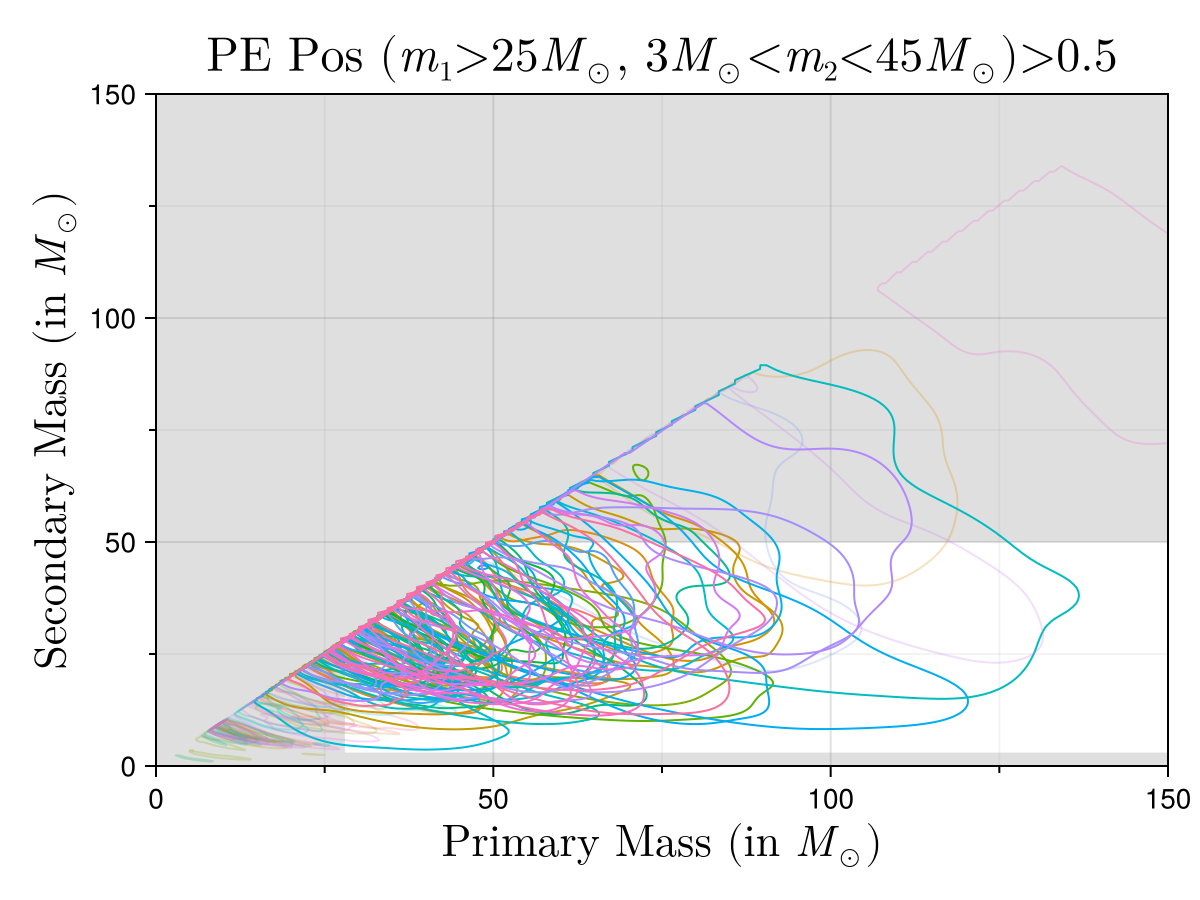

In [8]:
function frac_mass_bounds(df, m1_min, m2_min, m2_max)
    m1s = df[!, :mass_1_source]
    m2s = df[!, :mass_2_source]
    p_in = sum((m1s .> m1_min) .&& (m2s .> m2_min) .&& (m2s .< m2_max)) / length(m1s)
    p_in
end

function m1m2_kde_plot(df;
    m1_min = 28.0,
    m2_min = 3.0,
    m2_max = 50.0,
    include_legend=false,
    p_cut=[0.9, 0.5, 0.1],
    p_cut_eventlist=0.0,
    rng=Random.default_rng(),
    far_thresh=1,
    alpha_factor=0.25,
    level=0.1,
    draw_cut_lines=false
)
    if p_cut != p_cut_eventlist
        @info("Events will be plotted with p > $(p_cut_eventlist), but reduced by alpha*=$(alpha_factor) at thresholds p < $(p_cut)")
    end

    evt_groups = DataFrames.groupby(df, :gwname)

    # Only apply chirp mass and FAR filtering — no m1/m2 filter
    evt_groups = [
    evt for evt in evt_groups
    if frac_mass_bounds(evt, m1_min, m2_min, m2_max) >= p_cut_eventlist
]


    cs = categorical_palette(length(evt_groups))

    mlow = 0.0
    mhigh = 150.0

    f = Figure()
    a = Axis(f[1, 1];
        xlabel=L"\mathrm{Primary~Mass~(in~} M_\odot)",
        ylabel=L"\mathrm{Secondary~Mass~(in~} M_\odot)",
        xlabelsize=22, ylabelsize=22, titlesize=24,
        limits=(mlow,mhigh,mlow,mhigh),
        title=L"\mathrm{PE~Pos}~(m_1>25M_{\odot},~3M_{\odot}<m_2<45M_{\odot})>0.5",
        xminorgridvisible=true, xminorticksvisible=true,
        yminorgridvisible=true, yminorticksvisible=true
    )

    # Exclusion regions (shaded)
    if draw_cut_lines
        m1_min = 28.0
        m2_min = 3.0
        m2_max = 50.0

        poly!(a, [0.0, m1_min, m1_min], [0.0, 0.0, m1_min], color=(:grey, 0.25))
        poly!(a, [m1_min, m1_min, mhigh, mhigh], [0.0, m2_min , m2_min, 0.0], color=(:grey, 0.25))
        poly!(a, [m2_max, mhigh, mhigh], [m2_max, mhigh, m2_max], color=(:grey, 0.25))
    end

    # m1 < m2 region
    band!(a, [mlow, mhigh], [mlow, mhigh], [mhigh, mhigh], color=(:grey, 0.25))

    @progress for (i, evt) in enumerate(evt_groups)
        alpha = 1.0
        p = frac_mass_bounds(evt, m1_min, m2_min, m2_max)
        for pc in p_cut
            if p > pc
                break
            else
                alpha *= alpha_factor
            end
        end

        c = (cs[i], alpha)
        npe = size(evt, 1)
        ndraw = min(256, npe)
        draw_inds = randperm(rng, npe)[1:ndraw]

        evt_draw = evt[draw_inds, :]

        x = evt_draw[!, :mass_1_source]
        y = evt_draw[!, :mass_2_source]
        kde_pts = vcat(x', y')
        k = KDE(kde_pts)
        p_kde_pts = [pdf(k, [kde_pts[1,i], kde_pts[2,i]]) + pdf(k, [kde_pts[2,i], kde_pts[1,i]]) for i in axes(kde_pts, 2)]

        p = quantile(p_kde_pts, level)

        dx = maximum(x) - minimum(x)
        xgrid = range(minimum(x)-0.1*dx, maximum(x)+0.1*dx, length=128)

        dy = maximum(y) - minimum(y)
        ygrid = range(minimum(y)-0.1*dy, maximum(y)+0.1*dy, length=129)

        zgrid = [(x ≥ y ? pdf(k, [x, y]) + pdf(k, [y, x]) : zero(x)) for x in xgrid, y in ygrid]

        contour!(a, xgrid, ygrid, zgrid; levels=[p], color=c)
    end

    if include_legend
        Legend(f[2,1],
            [LineElement(color=cs[i], linestyle=nothing) for i in 1:length(evt_groups)],
            [evt[1, :gwname] for evt in evt_groups],
            nbanks=3)
    end

    return f
end

f = m1m2_kde_plot(all_pe; p_cut=0.5, p_cut_eventlist=0.0, draw_cut_lines=true)
#save(joinpath(@__DIR__, "..", "figures", "m1_m2_kde.pdf"), f, px_per_unit = 3)
f

## $q-\chi_{\mathrm{eff}}$ Plane

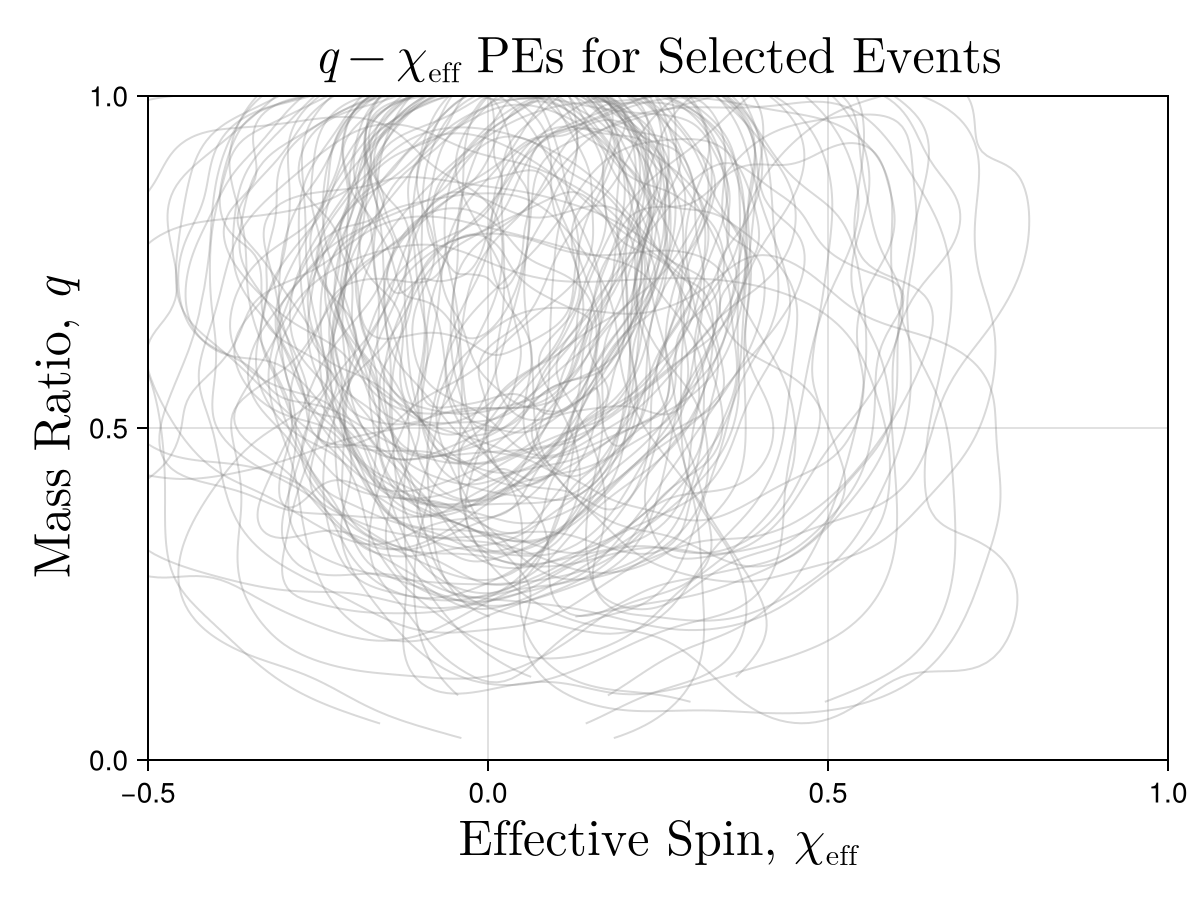

In [9]:
# Grouped data
pe_grouped = groups
rng = Random.Xoshiro(0xaf91589a0f32ada4)

# Create figure and axis
f = Figure()
a = Axis(f[1, 1],
    xlabel = L"\mathrm{Effective~Spin,~}\chi_\mathrm{eff}",
    ylabel = L"\mathrm{Mass~Ratio,~}q",
    xlabelsize = 25,
    ylabelsize = 25,
    titlesize=25,
    limits = ((-0.5, 1.0), (0, 1)),  # chi_eff from -1.2 to 1.2, q from 0 to 1
    title=L"q-\chi_{\mathrm{eff}}~\mathrm{PEs~for~Selected~Events}"
)

# Background: all events in grey
@progress for evt in pe_grouped
    inds = rand(rng, 1:size(evt, 1), 256)
    e = evt[inds, :]
    e = filter(:mass_ratio => q -> q ≤ 1, e)
    isempty(e) && continue
    kdecontour!(a, e.chi_eff, e.mass_ratio, color = (:grey, 0.3), levels = [0.1])
end

# Save the figure
#save(joinpath(@__DIR__, "..", "figures", "q_chieff_kde.pdf"), f, px_per_unit = 3)

f

## z Space

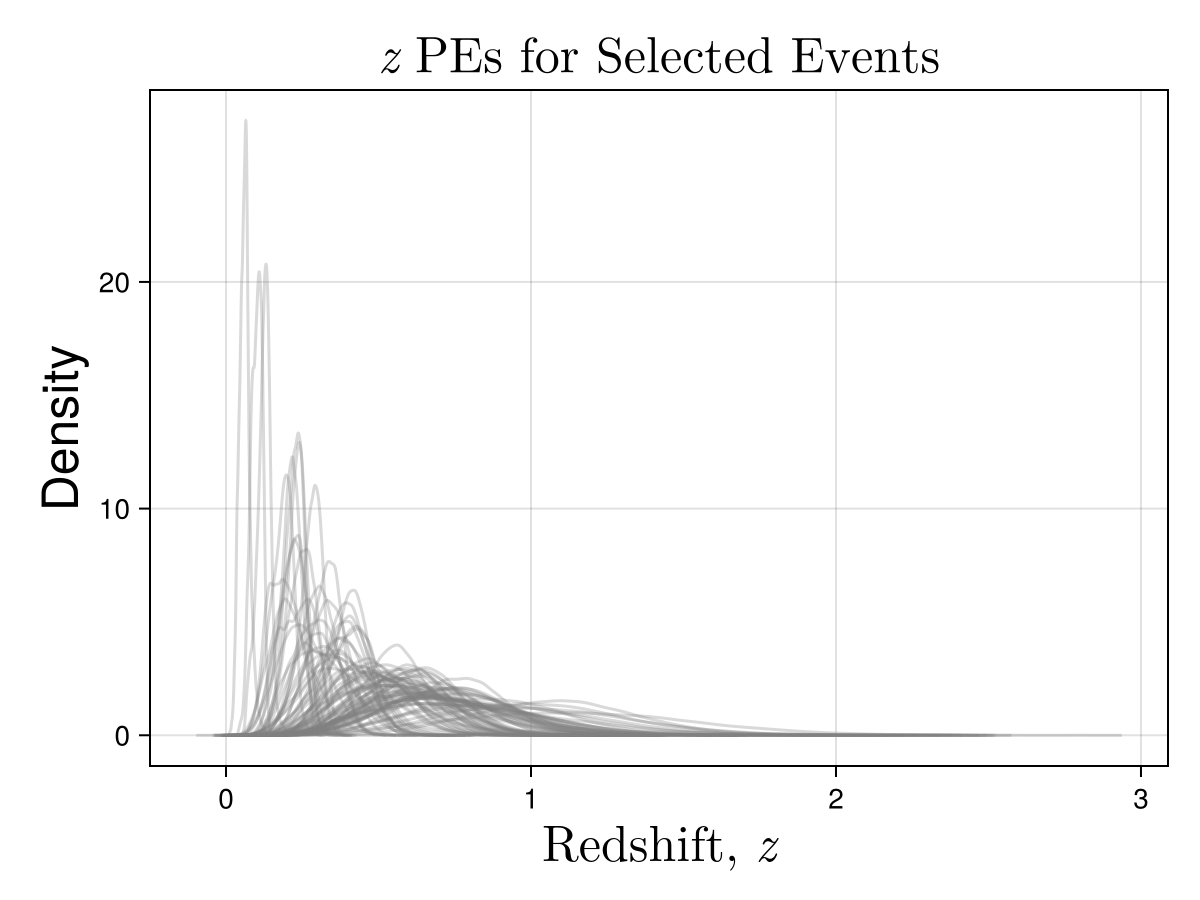

In [10]:
using KernelDensity
# Grouped data
pe_grouped = groups

# Set up figure and axis
f = Figure()
a = Axis(f[1, 1],
    xlabel = L"\mathrm{Redshift,~} z",
    ylabel = "Density",
    xlabelsize = 25,
    ylabelsize = 25,
    titlesize=25,
    title=L"z~\mathrm{PEs~for~Selected~Events}"
)

# Plot all PE redshift KDEs in grey
for evt in pe_grouped
    z = evt.redshift
    if length(z) < 2
        continue
    end
    kde_result = KernelDensity.kde(z)
    lines!(a, kde_result.x, kde_result.density, color = (:grey, 0.3))
end

# Save the figure
#save(joinpath(@__DIR__, "..", "figures", "z_kde.pdf"), f, px_per_unit = 3)

f